In [2]:
import torch
from torchvision import datasets, transforms,models
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split
from torchsummary import summary
import time
import seaborn as sns
# import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [30]:
device

device(type='cuda')


I have provided visualizations at the bottom of the notebook. I have included some explanations for how I planned & constructed my model

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally with a default 50% chance
    transforms.RandomRotation(10),
    transforms.GaussianBlur()
])


train_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 64
total_size = len(train_data)

# Determine the split ratio
train_ratio = 0.9
validation_ratio = 1 - train_ratio

# Calculate lengths
train_length = int(total_size * train_ratio)
validation_length = total_size - train_length  # ensures no data point is left out

# Split the dataset
train_dataset, valid_dataset = random_split(train_data, lengths=[train_length, validation_length])
# train_dataset, valid_dataset = random_split(train_data, lengths=[55000, 5000])
trainloader = DataLoader(train_data,batch_size=50)
testloader = DataLoader(test_data,batch_size=50)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


I decided to experiment with modularizing my convolutions. I defined a 'longblock' class as a container for my deep convolutions. 'Shortblock' is for shorter but wider convolutions (bigger kernel and less channels)

After experimenting, I found that adding skip connections vastly improved performance. The original model had the long & shortblocks, as well as batch norm. The test performance wasn't good, so I added dropout and it brought it above 80%

In [3]:
class Longblock(nn.Module):
    """
    Takes input with 3 channels. Follows shortblock
    Outputs 
    """
    def __init__(self,in_channels,out_channels,first=False):
        super(Longblock,self).__init__()
        self.first = first
        #Test convolution, just ads more channels
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=160, out_channels=out_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.bn2 = nn.BatchNorm2d(num_features=160)
        # self.bn3 = nn.BatchNorm2d(num_features=3)
        self.adjust_channels = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        #For every step, apply RELU & Batch norm
        identity = x
        identity = self.adjust_channels(identity)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv3(x)
        # x = F.max_pool2d(x,kernel_size=2)
        x += identity
        x = self.dropout(x)

        return x

class Shortblock(nn.Module):
    """
    Takes input with 3 channels
    Fatter than the longblock.
    """
    def __init__(self,in_channels,out_channels):
        super(Shortblock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=20, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=64, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=20)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        #For every step, apply RELU & Batch norm. Then dropout and maxpool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = F.max_pool2d(x,kernel_size=3)
        return x
    
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #Resizes to 3 channels from 1
        # self.resizeconv = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,padding=1)
        self.shortblock = Shortblock(3,128)
        self.longblock1 = Longblock(128,128)
        self.longblock2 = Longblock(128,256)
        self.longblock3 = Longblock(256,512)
        self.longblock4 = Longblock(512,256)
        self.shortblock2 = Shortblock(256,128)
        self.longblock5 = Longblock(128,64)

        self.Linear1 = nn.Linear(576,100)
        self.Linear2 = nn.Linear(100,500)
        self.Linear3 = nn.Linear(500,10)

    def forward(self,x):

        #Convolution Blocks
        #This totals 10 convolutions. Resize is to add more channels initially, then the other blocks handle the bulk of it. Each block has 3 convolutions
        # x = self.resizeconv(x)
        x = self.shortblock(x)

        x = self.longblock1(x)
        x = self.longblock2(x)
        x = self.longblock3(x)
        x = self.longblock4(x)
        x = self.shortblock2(x)
        x = self.longblock5(x)
        self.dropout = nn.Dropout(0.2)
        # print(x.shape)

        #Flatten and run through linear layers
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x = self.dropout(x)
        x = self.Linear3(x)
        return x


In [5]:
print(Model())

Model(
  (shortblock): Shortblock(
    (conv1): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv2): Conv2d(20, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (longblock1): Longblock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(160, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(160, eps=1e-05, mome

In [55]:

summary(Model().to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]           2,960
       BatchNorm2d-2           [-1, 20, 32, 32]              40
            Conv2d-3           [-1, 64, 32, 32]          62,784
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5          [-1, 128, 32, 32]         401,536
       BatchNorm2d-6          [-1, 128, 32, 32]             256
           Dropout-7          [-1, 128, 32, 32]               0
        Shortblock-8          [-1, 128, 10, 10]               0
            Conv2d-9          [-1, 128, 10, 10]          16,512
           Conv2d-10          [-1, 128, 10, 10]         147,584
      BatchNorm2d-11          [-1, 128, 10, 10]             256
           Conv2d-12          [-1, 160, 10, 10]         184,480
      BatchNorm2d-13          [-1, 160, 10, 10]             320
           Conv2d-14          [-1, 128,

In [56]:
random_seed = 1
batch_size = 256
learning_rate = 0.03
num_epochs = 15
num_classes = 10
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

In [57]:
torch.manual_seed(random_seed)
model = Model()
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
#For storing data on losses
train_loss= []

start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(trainloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        
        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(trainloader):03d} | "
                f"Loss: {loss:.4f}"
            )
    
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")

    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, trainloader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    if epoch % 5 == 0:
        ts_acc = accuracy(model, testloader, device)
        print(f"Test Accuracy: {ts_acc:0.3f}")

    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min")
    train_loss.append(loss)
print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")


Epoch: 001/015 | Batch: 100/1000 | Loss: 1.8576
Epoch: 001/015 | Batch: 200/1000 | Loss: 1.7261
Epoch: 001/015 | Batch: 300/1000 | Loss: 1.6687
Epoch: 001/015 | Batch: 400/1000 | Loss: 1.5434
Epoch: 001/015 | Batch: 500/1000 | Loss: 1.2419
Epoch: 001/015 | Batch: 600/1000 | Loss: 1.3140
Epoch: 001/015 | Batch: 700/1000 | Loss: 1.6638
Epoch: 001/015 | Batch: 800/1000 | Loss: 1.1280
Epoch: 001/015 | Batch: 900/1000 | Loss: 1.4253
Epoch: 001/015 | Batch: 1000/1000 | Loss: 1.4685
Epoch: 001 Learning Rate 0.03000000 -> 0.03000000
Train Accuracy: 56.016
Validation Accuracy: 56.160
Test Accuracy: 56.000
Time elapsed so far: 0.78 min
Epoch: 002/015 | Batch: 100/1000 | Loss: 1.5867
Epoch: 002/015 | Batch: 200/1000 | Loss: 1.2620
Epoch: 002/015 | Batch: 300/1000 | Loss: 1.2938
Epoch: 002/015 | Batch: 400/1000 | Loss: 1.1416
Epoch: 002/015 | Batch: 500/1000 | Loss: 0.8978
Epoch: 002/015 | Batch: 600/1000 | Loss: 1.0315
Epoch: 002/015 | Batch: 700/1000 | Loss: 1.3266
Epoch: 002/015 | Batch: 800/10

In [58]:
model = model.eval()
ts_acc = accuracy(model, testloader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")

Test Accuracy: 81.000


In [59]:
# torch.save(model.state_dict(), 'model_state_dict.pth')


Evaluation:

In [60]:
model.eval()

#Tensors for ypred and ytrue
ypred = torch.tensor([], dtype=torch.long, device=device)
ytrue = torch.tensor([], dtype=torch.long, device=device)

with torch.no_grad():
    for imgs, labels in testloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        logits = model(imgs)
        _, label_pred = torch.max(logits, axis=1)
        
        ypred = torch.cat((ypred, label_pred))
        ytrue = torch.cat((ytrue, labels))
ypred = ypred.cpu().numpy()
ytrue = ytrue.cpu().numpy()

Visualizations:

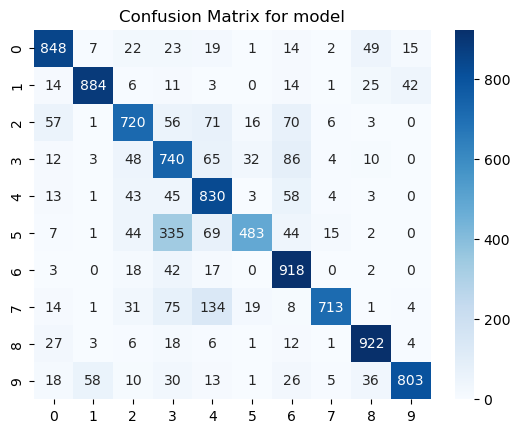

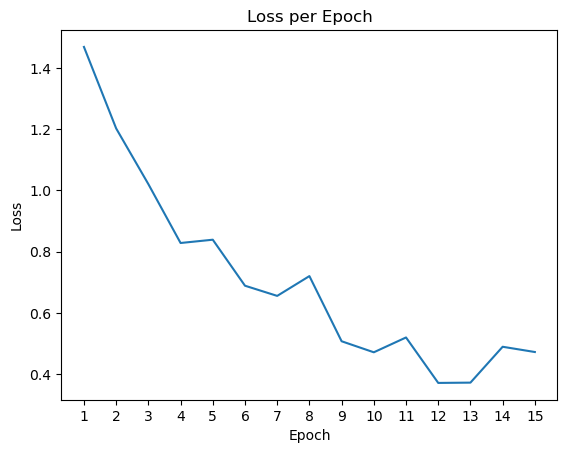

In [61]:
cm = confusion_matrix(ytrue,ypred,labels=[*range(10)])
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("Confusion Matrix for model")
plt.show()

#Line plot for loss
plt.plot([*range(1,num_epochs+1)],[x.cpu().detach().numpy() for x in train_loss])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([*range(1,num_epochs+1)])
plt.title("Loss per Epoch")
plt.show()